<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/SingleSubjSVM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis and Visualization of Single Subject SVM
-This notebook will summarize statistics for Single Subject SVM
-Create boxplots to look at spread of data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/single_subject
!ls

Cloning into 'teambrainiac'...
remote: Enumerating objects: 2125, done.
remote: Total 2125 (delta 0), reused 0 (delta 0), pack-reused 2125
Receiving objects: 100% (2125/2125), 148.51 MiB | 11.83 MiB/s, done.
Resolving deltas: 100% (1391/1391), done.
/content/teambrainiac/source
access_data.py			    process.py
brain_viz_single_subj.py	    single_subject.py
BuildSingleSubjectSVM_Models.ipynb  SingleSubjectSVM.ipynb
data				    SingleSubjSVM_Analysis.ipynb
DL				    streamlit
group_svm			    utils.py
helper				    VisualizationPlayground.ipynb
__init__.py			    VisualizationsNotebook.ipynb


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


In [78]:
# Import libraries
!pip install boto3 nilearn nibabel
#to load data
import pickle
#common packages we need
import numpy as np
import pandas as pd
#for brain imaging
import nibabel as nib
from nilearn import plotting, image
#for making graphs
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline
import seaborn as sns
from nilearn.image import threshold_img
#sklearn packages needed
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,auc,roc_auc_score,precision_recall_curve,precision_score,recall_score,roc_curve
from sklearn.svm import SVC
#import code for processing and visualizing data
from single_subject import *
from access_data import *
from brain_viz_single_subj import *

In [74]:
#get common variables we need across multiple cells
data_path_dict = get_data_dict()
subj_ids, _ = get_subj_information(data_path_dict)
_ , y_test,_= get_labels(data_path_dict)
##get brain images
affine_image,t1_image,mni_image = get_brain_templates()

In [51]:
##setting mask list
#masks we want to grab data on, needs to be nested list for cell to run
#indices of the masks we want 0 = whole brain mask and masks minus ROIs, 1 = ROIs
mask_indices = [0,1]
mask_list = []
for ind in mask_indices:
  mask_dict = get_mask_data(data_path_dict,ind)  
  masks = list(mask_dict.keys())[3:]
  mask_list.append(masks)
# Example of building your own
# mask_dict = get_mask_data(data_path_dict,0)
# mask_list = [['mask']]
# mask_list_small = [['mask'],mask_list[1]]
# mask_list_small

In [52]:
#grab results
data_paths = []
for mask_ind in mask_indices:
  for mask in mask_list[mask_ind]:
    data_paths.append(f'/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/models/{mask}_tr_1_2_subject_models.pkl')

In [ ]:
from sklearn import metrics
#this cell grabs all subject data
metrics_list = [] #initialize empty list
inc_trials = np.where(y_test==1) #get indices of increase trials
dec_trials = np.where(y_test==0) #get indices of decrease trials
#iterate of data paths
for data_path in data_paths: 
  data = open_pickle(data_path) #open data file
  mask = list(data.keys())[0] #get mask
  subj_data = data[mask] #grab all subjects data
  for subj_id in subj_ids:
    subj_predicts = subj_data[subj_id]['predicts'] #get individual subject predictions
    #set group type
    if subj_id[0] == '1': #if subj id = 1 then adolescent, else young adult
      group = 'Adolescent'
    else:
      group = 'Young Adult'
    #iterate over runs
    for run in list(subj_predicts.keys()):
      subjs_acc_list = [mask,group,subj_id] #initialize subject accuracy list
      subjs_acc_list.append(run) #append run name
      subjs_acc_list.append(accuracy_score(y_test,subj_predicts[run]['predicts'])) #get accuracy score
      subjs_acc_list.append(accuracy_score(y_test[inc_trials],subj_predicts[run]['predicts'][inc_trials])) #get sensitivity (same as recall tp/(tp+fn))
      subjs_acc_list.append(accuracy_score(y_test[dec_trials],subj_predicts[run]['predicts'][dec_trials])) #get specificity (tn/(tn+fp))
      subjs_acc_list.append(precision_score(y_test,subj_predicts[run]['predicts'])) #get precision scores (tp/(tp+fp))
      subjs_acc_list.append(recall_score(y_test,subj_predicts[run]['predicts'])) #get recall scores (tp/(tp+fn))
      subjs_acc_list.append(roc_auc_score(y_test,subj_predicts[run]['proba'][:,1])) #get auc score for positive class
      print(subjs_acc_list) #print
      metrics_list.append(subjs_acc_list) #append to list for further analysis
  #create individual mask df
  mask_df = pd.DataFrame(metrics_list,columns=['Mask Type','Group','Subject','Run','Accuracy','Sensitivity','Specificity','Precision','Recall','AUC Positive Class'])
  #save file
  mask_df.to_csv(f'/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/metrics_{mask}_tr_2_te3_4.csv')
#create dataframe from list
metrics_df = pd.DataFrame(metrics_list,columns=['Mask Type','Group','Subject','Run','Accuracy','Sensitivity','Specificity','Precision','Recall','AUC Positive Class'])
#savefile
metrics_df.to_csv('/content/drive/My Drive/data/singlesubjectmodels/metrics_allmask_tr_2_te3_4.csv')

In [10]:
#create summary tables
#create summary tables for all subjects
all_subjects_runs_combined = metrics_df.groupby(['Mask Type']).mean()
print(all_subjects_runs_combined)
all_subjects_runs_combined.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/summary_stats_all_subjects_runs_combined_tr_2_te3_4.csv')

                     Accuracy  Sensitivity  Specificity  Precision    Recall  \
Mask Type                                                                      
acc_aal              0.640339     0.658883     0.621795   0.638786  0.658883   
anterior_insula_aal  0.585508     0.596841     0.574176   0.584113  0.596841   
mPFC                 0.590430     0.611264     0.569597   0.587778  0.611264   
mask                 0.701809     0.703068     0.700549   0.705419  0.703068   
masksubACC           0.703182     0.703526     0.702839   0.707224  0.703526   
masksubAI            0.702610     0.703984     0.701236   0.705965  0.703984   
masksubNAcc          0.702038     0.702839     0.701236   0.705890  0.702839   
masksubmPFC          0.702038     0.703068     0.701007   0.705684  0.703068   
nacc_aal             0.602221     0.608745     0.595696   0.603655  0.608745   

                     AUC Positive Class  
Mask Type                                
acc_aal                        0.69

In [11]:
#summary table by run on all subjects
all_subjects_by_runs = metrics_df.groupby(['Mask Type','Run']).mean()
print(all_subjects_by_runs)
all_subjects_by_runs.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/summary_stats_all_subjects_by_runs_tr_2_te3_4.csv')

                            Accuracy  Sensitivity  Specificity  Precision  \
Mask Type           Run                                                     
acc_aal             run_03  0.679716     0.695055     0.664377   0.677705   
                    run_04  0.600962     0.622711     0.579212   0.599868   
anterior_insula_aal run_03  0.613553     0.632326     0.594780   0.610450   
                    run_04  0.557463     0.561355     0.553571   0.557775   
mPFC                run_03  0.611035     0.634615     0.587454   0.609068   
                    run_04  0.569826     0.587912     0.551740   0.566489   
mask                run_03  0.740156     0.740842     0.739469   0.745363   
                    run_04  0.663462     0.665293     0.661630   0.665475   
masksubACC          run_03  0.740842     0.739927     0.741758   0.747002   
                    run_04  0.665522     0.667125     0.663919   0.667446   
masksubAI           run_03  0.740842     0.742216     0.739469   0.745570   

In [12]:
# #summary table by group on runs combined
all_subjects_runs_combined_by_group = metrics_df.groupby(['Mask Type','Group']).mean()
print(all_subjects_runs_combined_by_group)
all_subjects_runs_combined_by_group.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/summary_stats_runs_combined_by_group.csv')

                                 Accuracy  Sensitivity  Specificity  \
Mask Type           Group                                             
acc_aal             Adolescent   0.618146     0.646825     0.589466   
                    Young Adult  0.678885     0.679825     0.677945   
anterior_insula_aal Adolescent   0.576840     0.594156     0.559524   
                    Young Adult  0.600564     0.601504     0.599624   
mPFC                Adolescent   0.576299     0.594156     0.558442   
                    Young Adult  0.614975     0.640977     0.588972   
mask                Adolescent   0.676407     0.680375     0.672439   
                    Young Adult  0.745927     0.742481     0.749373   
masksubACC          Adolescent   0.677489     0.680736     0.674242   
                    Young Adult  0.747807     0.743108     0.752506   
masksubAI           Adolescent   0.677309     0.681457     0.673160   
                    Young Adult  0.746554     0.743108     0.750000   
masksu

In [ ]:
# #summary table by group by runs
all_subjects_by_run_by_group = metrics_df.groupby(['Mask Type','Group','Run']).mean()
print(all_subjects_by_run_by_group)
all_subjects_by_run_by_group.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/summary_stats_by_run_by_group.csv')

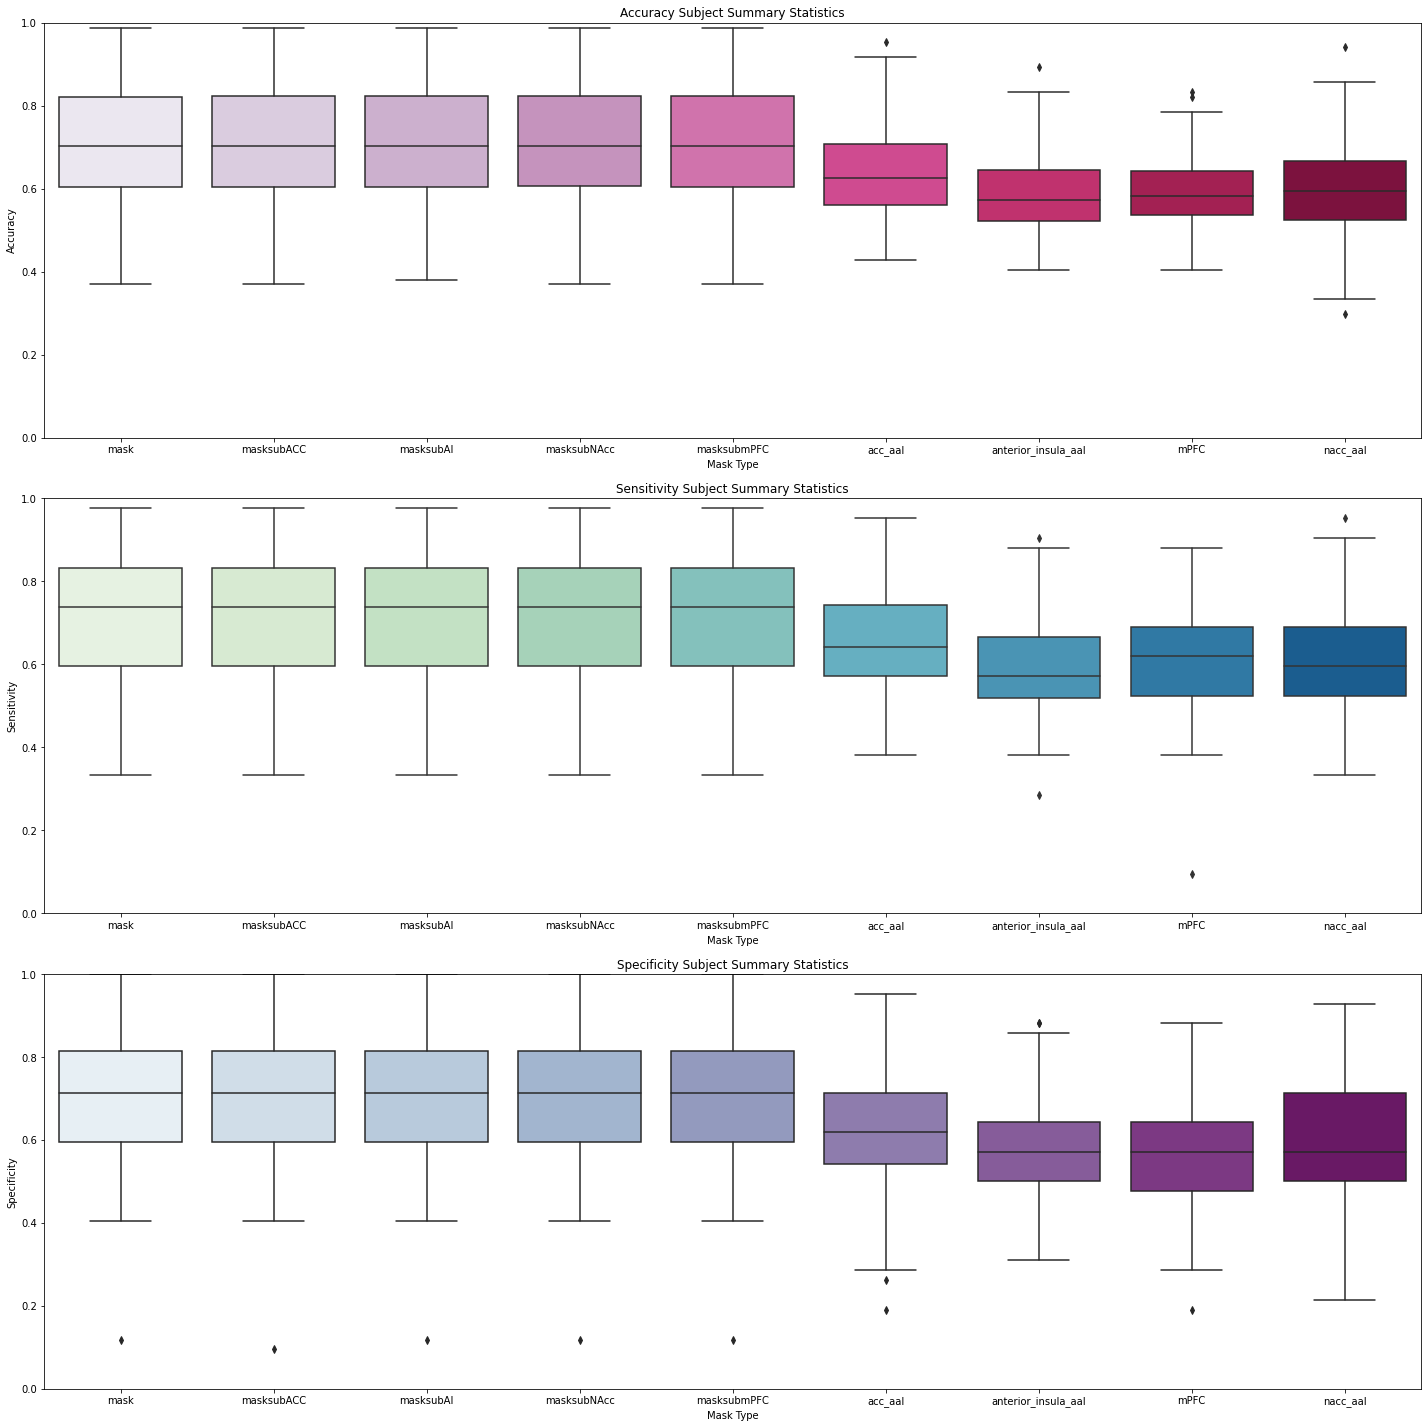

In [14]:
##create box plots accross all subjects runs combined
fig,axes=plt.subplots(3,1,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
metrics = ['Accuracy','Sensitivity','Specificity']
metrics = [('Accuracy','PuRd'),('Sensitivity','GnBu'),('Specificity','BuPu')]
for metric,color in metrics:
  sns.set(font_scale = 1)
  sns.boxplot(x='Mask Type',y=metric,data=metrics_df, ax=axes[row],palette=color) 
  axes[row].set_title(f'{metric} Subject Summary Statistics')
  axes[row].set_ylim(0,1)
  row +=1
fig.tight_layout()
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/boxplot_tr_2runs3_4_combined.png',dpi=200)

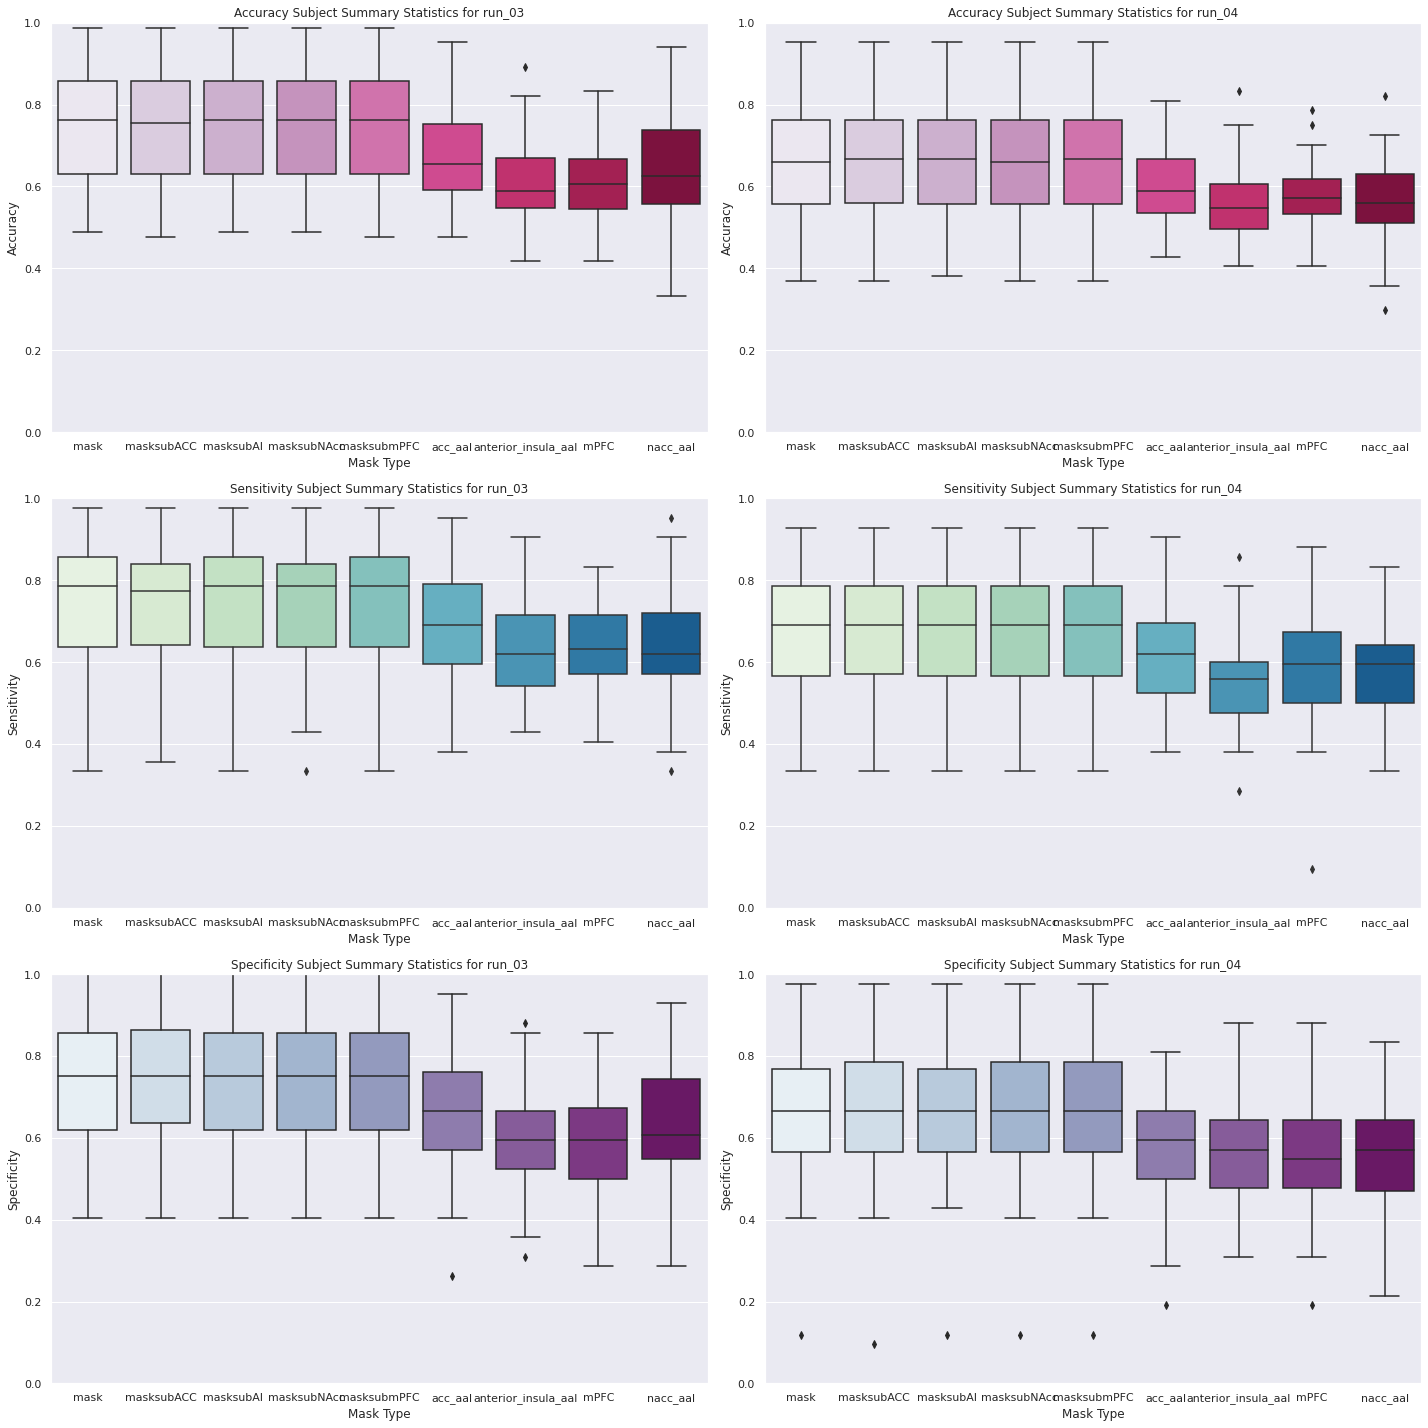

In [15]:
##create box plots accross all subjects by run
fig,axes=plt.subplots(3,2,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
metrics = ['Accuracy','Sensitivity','Specificity']
metrics = [('Accuracy','PuRd'),('Sensitivity','GnBu'),('Specificity','BuPu')]
for metric,color in metrics:
  for run in runs_test:
    df = metrics_df[metrics_df['Run']==run]
    sns.set(font_scale = 1)
    sns.boxplot(x='Mask Type',y=metric,data=df, ax=axes[row,column],palette=color) 
    axes[row,column].set_title(f'{metric} Subject Summary Statistics for {run}')
    axes[row,column].set_ylim(0,1)
    column+=1
  column=0
  row +=1
fig.tight_layout()
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/boxplot_tr_2runs3_4_separate.png',dpi=200)

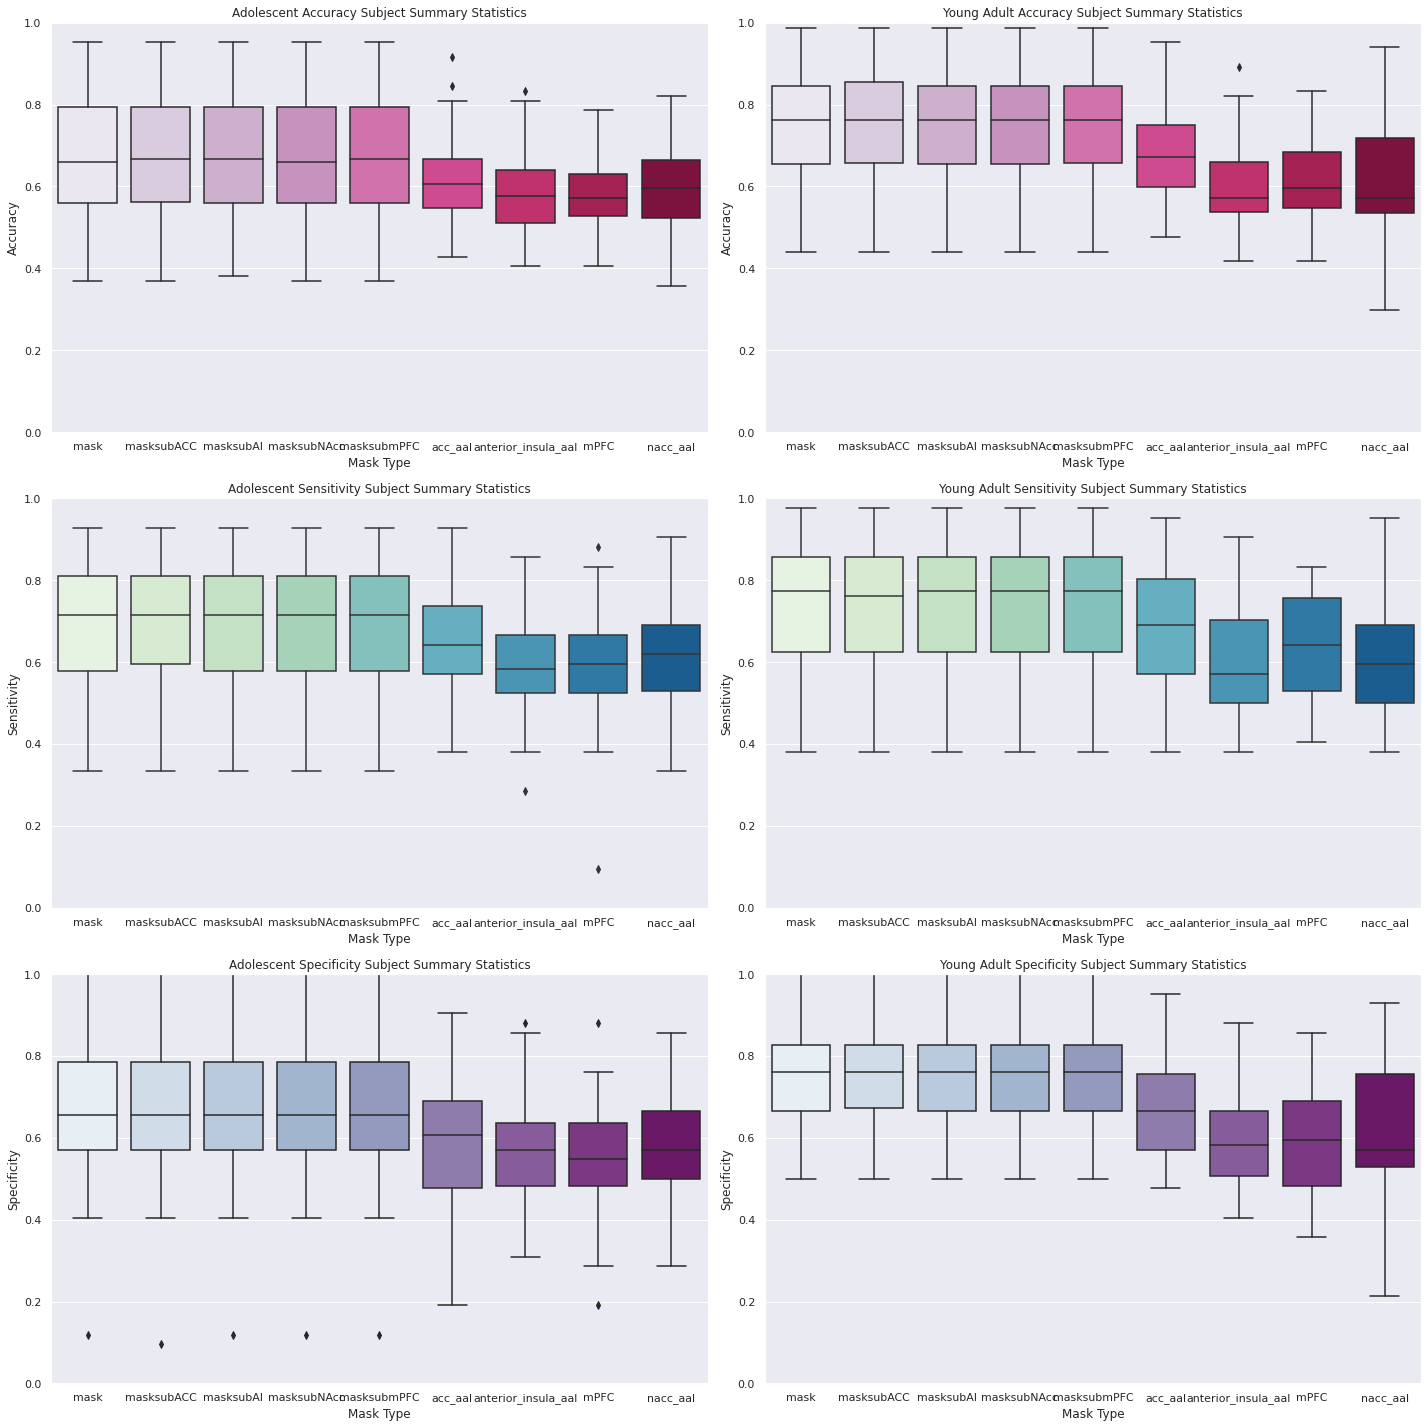

In [16]:
##create box plots accross all subjects just looking at all data
fig,axes=plt.subplots(3,2,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
metrics = [('Accuracy','PuRd'),('Sensitivity','GnBu'),('Specificity','BuPu')]
groups = ['Adolescent','Young Adult']
df = metrics_df[metrics_df['Mask Type']=='mask']
for metric,color in metrics:
  for group in groups:
    df = metrics_df[metrics_df['Group']==group]
    sns.set(font_scale = 1)
    sns.boxplot(x='Mask Type',y=metric,data=df, ax=axes[row,column],palette=color) 
    axes[row,column].set_title(f'{group} {metric} Subject Summary Statistics')
    axes[row,column].set_ylim(0,1)
    column +=1
  column = 0
  row +=1
fig.tight_layout() 
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/boxplot_tr_2_runs3_4_group_combined.png',dpi=200)

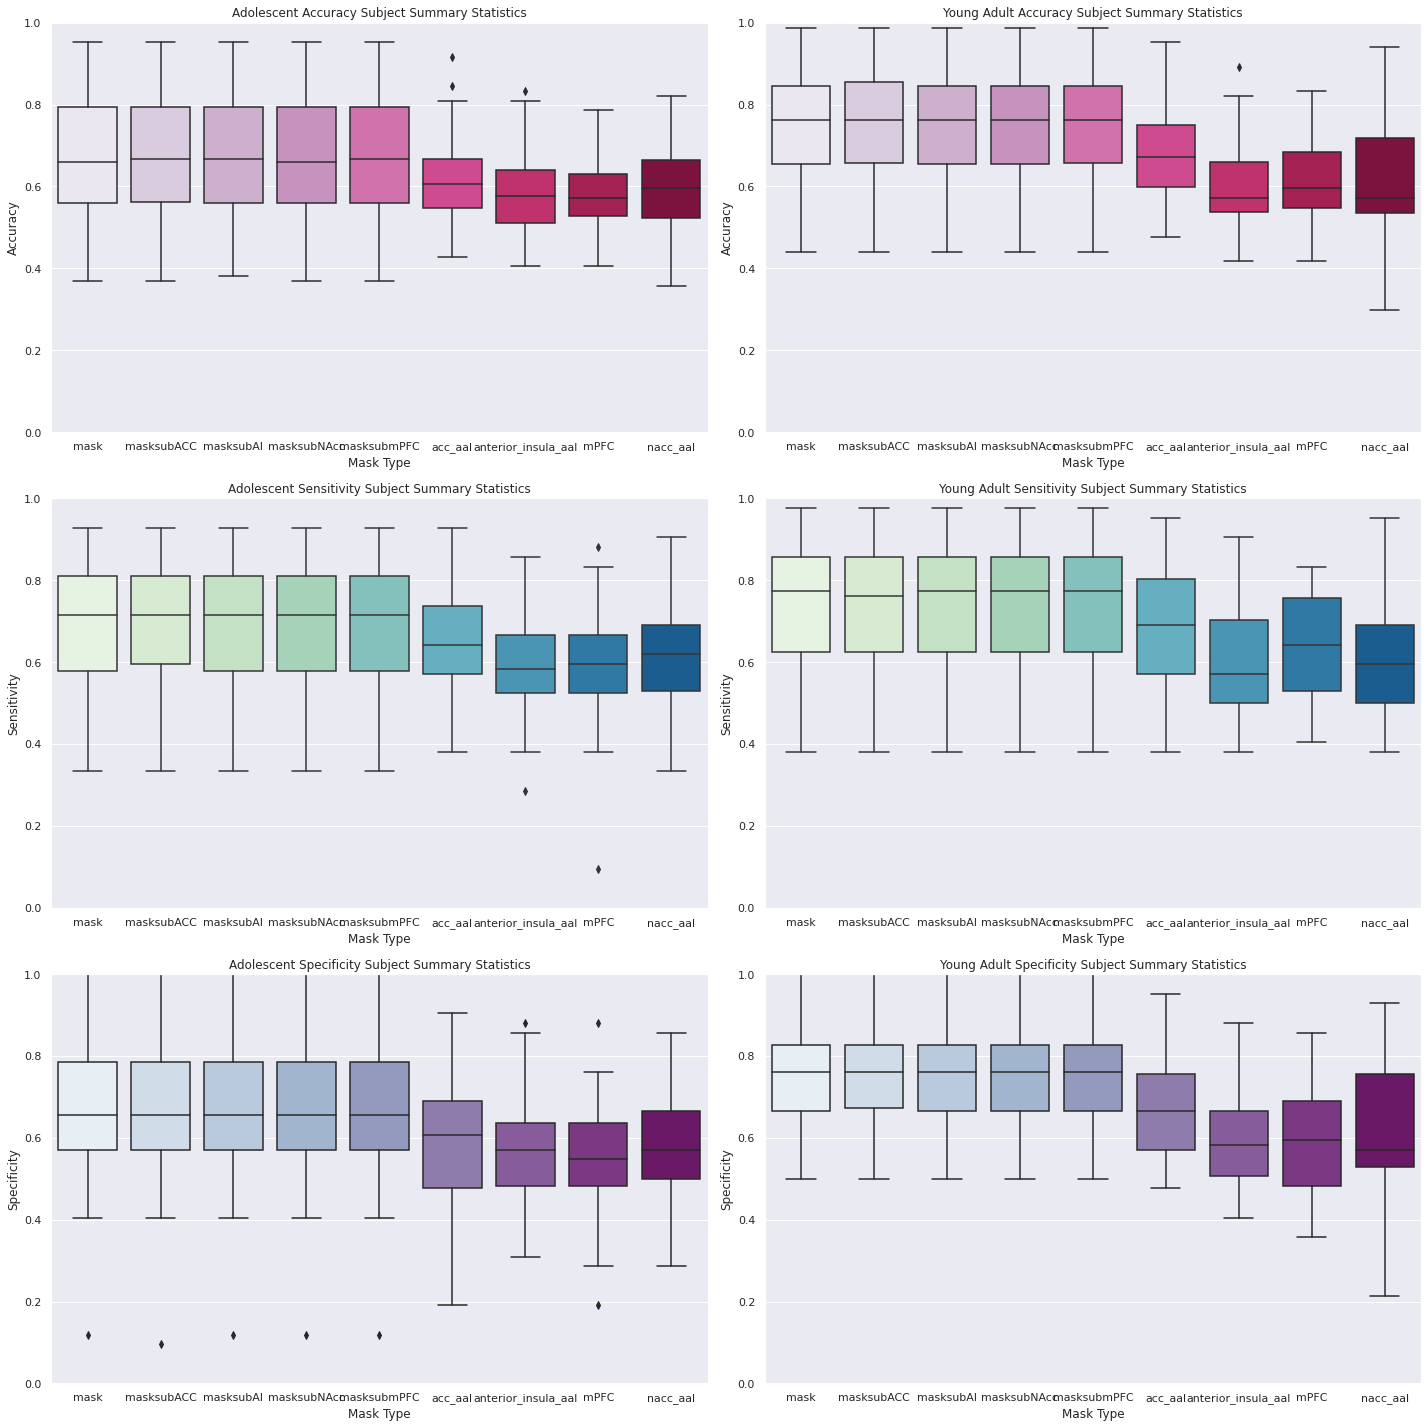

In [17]:
##create box plots accross all subjects just looking at all data
fig,axes=plt.subplots(3,2,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
metrics = [('Accuracy','PuRd'),('Sensitivity','GnBu'),('Specificity','BuPu')]
groups = ['Adolescent','Young Adult']
df = metrics_df[metrics_df['Mask Type']=='mask']
for metric,color in metrics:
  for group in groups:
    df = metrics_df[metrics_df['Group']==group]
    sns.set(font_scale = 1)
    sns.boxplot(x='Mask Type',y=metric,data=df, ax=axes[row,column],palette=color) 
    axes[row,column].set_title(f'{group} {metric} Subject Summary Statistics')
    axes[row,column].set_ylim(0,1)
    column +=1
  column = 0
  row +=1
fig.tight_layout() 
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/boxplot_tr_2_runs3_4_group_combined.png',dpi=200)

In [18]:
from scipy import stats
metrics_df.groupby(['Mask Type','Group']).agg({'Accuracy': ['mean','std']})
ttest_df = pd.DataFrame(columns=['Mask_Type','Mask_Compare','Group','Run','T_Test','P_value'])

In [ ]:
masks_ttest_list = []
for masks in mask_list:
  masks_ttest_list.extend(masks)
print(masks_ttest_list)
for mask_ttest in masks_ttest_list:
  print(mask_ttest)
  mask_ttest_acc = metrics_df[metrics_df['Mask Type']==mask_ttest]['Accuracy']
  for mask in masks_ttest_list:
    if mask==mask_ttest:
      continue
    mask_ttest_acc2 = metrics_df[metrics_df['Mask Type']==mask]['Accuracy']
    t_stat,p_value = stats.ttest_rel(mask_ttest_acc,mask_ttest_acc2)
    ttest_df = ttest_df.append({'Mask_Type': mask_ttest,
                                'Mask_Compare': mask,
                                'Group': 'All',
                                'Run': 'Combined',
                              'T_Test': t_stat,
                              'P_value': p_value},ignore_index=True)

In [ ]:
masks_ttest_list = []
runs_test = ['run_03','run_04']
for masks in mask_list:
  masks_ttest_list.extend(masks)
print(masks_ttest_list)
for mask_ttest in masks_ttest_list:
  print(mask_ttest)
  mask_ttest_acc3 = metrics_df[(metrics_df['Mask Type']==mask_ttest) & (metrics_df['Run']=='run_03')]['Accuracy']
  mask_ttest_acc4 = metrics_df[(metrics_df['Mask Type']==mask_ttest) & (metrics_df['Run']=='run_04')]['Accuracy']

  t_stat,p_value = stats.ttest_rel(mask_ttest_acc3,mask_ttest_acc4)
  ttest_df = ttest_df.append({'Mask_Type': mask_ttest,
                              'Mask_Compare': mask_ttest,
                              'Group': 'All',
                              'Run': 'Across',
                            'T_Test': t_stat,
                            'P_value': p_value},ignore_index=True)

In [ ]:
masks_ttest_list = []
groups = ['Adolescent','Young Adult']
for masks in mask_list:
  masks_ttest_list.extend(masks)
print(masks_ttest_list)
for mask_ttest in masks_ttest_list:
  print(mask_ttest)
  mask_ttest_acc_adol = metrics_df[(metrics_df['Mask Type']==mask_ttest) & (metrics_df['Group']=='Adolescent')]['Accuracy']
  mask_ttest_acc_ya = metrics_df[(metrics_df['Mask Type']==mask_ttest) & (metrics_df['Group']=='Young Adult')]['Accuracy']

  t_stat,p_value = stats.ttest_ind(mask_ttest_acc_adol,mask_ttest_acc_ya)
  ttest_df = ttest_df.append({'Mask_Type': mask_ttest,
                              'Mask_Compare': mask_ttest,
                              'Group': 'By Group',
                              'Run': 'Across',
                            'T_Test': t_stat,
                            'P_value': p_value},ignore_index=True)

In [22]:
ttest_df.to_csv('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/summary_statistics/tr_2_te_3_4_ttest_table.csv')

In [ ]:
top_n = metrics_df[metrics_df['Mask Type']=='mask'].nlargest(3,'Accuracy')
bottom_n = metrics_df[metrics_df['Mask Type']=='mask'].nsmallest(3,'Accuracy')
print(top_n)
print(bottom_n)

In [ ]:
#get top performers and bottom performers data for visualization
performance_list=['Top Performers','Bottom Performers'] #create list to indicate top and bottom performers
#load data file (looking at whole brain mask only)
performance_dict = {} #initialize performance
#iterate over data paths
for data_path in data_paths: 
  data = open_pickle(data_path) #open data file
  mask = list(data.keys())[0] #get mask
  data_mask = data[mask] #subjects masked data
  performance_dict[mask] = {} #initialize mask dictionary in performance
#iterate over performance type
  for performance in performance_list:
    performance_dict[mask][performance] = {} #initialize performance dict in mask dict  
    if performance == 'Top Performers':
      top_n = metrics_df[(metrics_df['Mask Type']==mask) & (metrics_df['Run']=='run_03')].nlargest(3,'Accuracy') #get top performers based on accuracy (run 3 only)
      top_n_list = top_n.Subject.unique() #get top performers subject ids
      #iterate over subject ids
      for subj_id in top_n_list:
        #set group type
        if subj_id[0] == '1': #if subj id = 1 then adolescent, else young adult
          group = 'Adolescent'
        else:
          group = 'Young Adult'
        performance_dict[mask][performance][subj_id] = {} #initialize subject dictionary
        performance_dict[mask][performance][subj_id]['Group'] = group #set group type
        performance_dict[mask][performance][subj_id] = data_mask[subj_id] #store data     
    else:
      bottom_n = metrics_df[(metrics_df['Mask Type']==mask) & (metrics_df['Run']=='run_03')].nsmallest(3,'Accuracy') #get bottom performers based on accuracy (run 3 only)
      bottom_n_list = bottom_n.Subject.unique() #get bottom performers subject ids   
      for subj_id in bottom_n_list:
        performance_dict[mask][performance][subj_id] = {}
        performance_dict[mask][performance][subj_id]['Group'] = group
        performance_dict[mask][performance][subj_id] = data_mask[subj_id]
      


In [59]:
performance_dict['mask'].keys()

dict_keys(['Top Performers', 'Bottom Performers'])

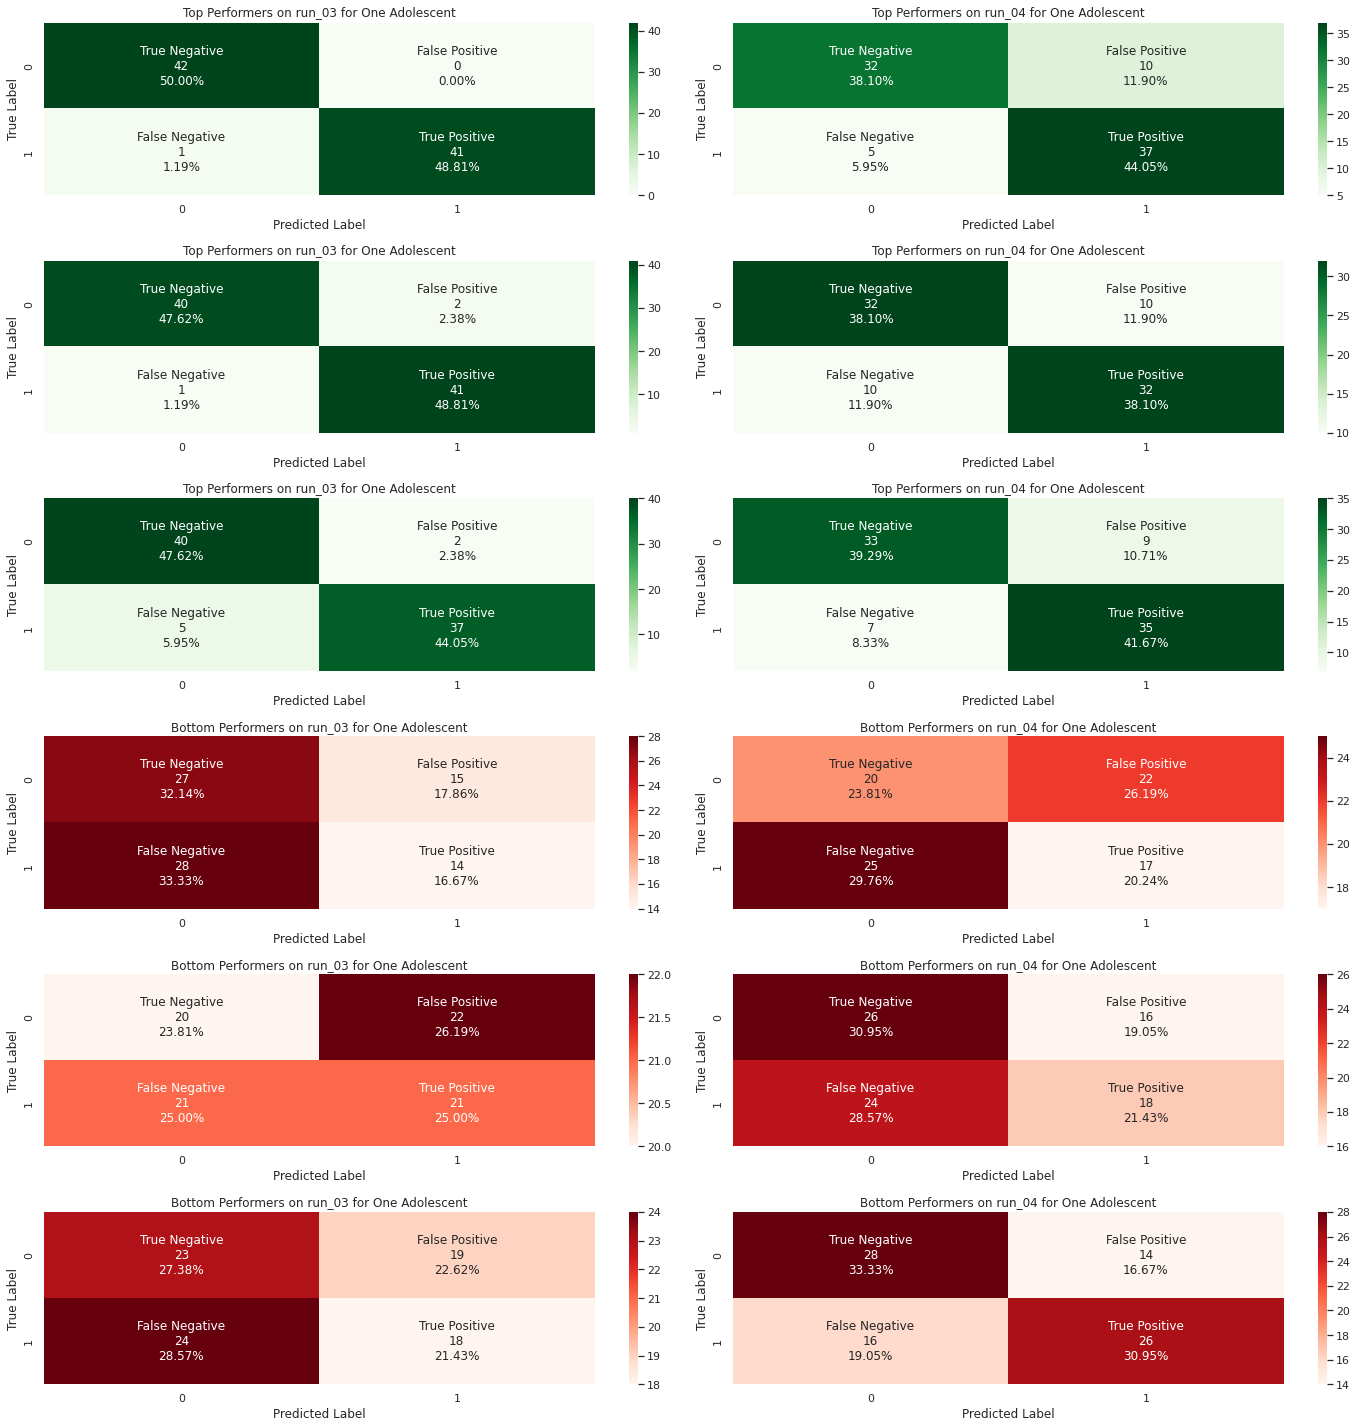

In [72]:
##create confusion matrix across top and bottom performers
fig,axes=plt.subplots(6,2,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
performance_list=['Top Performers','Bottom Performers']
mask_performance_dict = performance_dict['mask']
for performance in list(mask_performance_dict.keys()):
  if performance == 'Top Performers':
    color = 'Greens'
  else:
    color = 'Reds'
  mask_pf_sub = mask_performance_dict[performance]
  for subj_id in list(mask_pf_sub.keys()):
    subj_predicts = mask_pf_sub[subj_id]['predicts']
    for run in list(subj_predicts.keys()):
      predicts = subj_predicts[run]['predicts']
      cm = confusion_matrix(y_test,predicts)
      sns.set(font_scale = 1)
      group_names = ['True Negative','False Positive','False Negative','True Positive']
      group_counts = ["{0:0.0f}".format(value) for value in
                  cm.flatten()]
      group_percentages = ["{0:.2%}".format(value) for value in
                          cm.flatten()/np.sum(cm)]
      labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                zip(group_names,group_counts,group_percentages)]
      labels = np.asarray(labels).reshape(2,2)
      sns.heatmap(cm, annot=labels, fmt='', cmap=color, ax=axes[row,column])
      axes[row,column].set_xlabel("Predicted Label")
      axes[row,column].set_ylabel("True Label")
      axes[row,column].set_title(f'{performance} on {run} for One {group}')
      column +=1
    column = 0
    row+=1
fig.tight_layout() 
fig.savefig('/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/box_plots/confusion_matrix_tr_2_runs3_4_by_run.png',dpi=200)

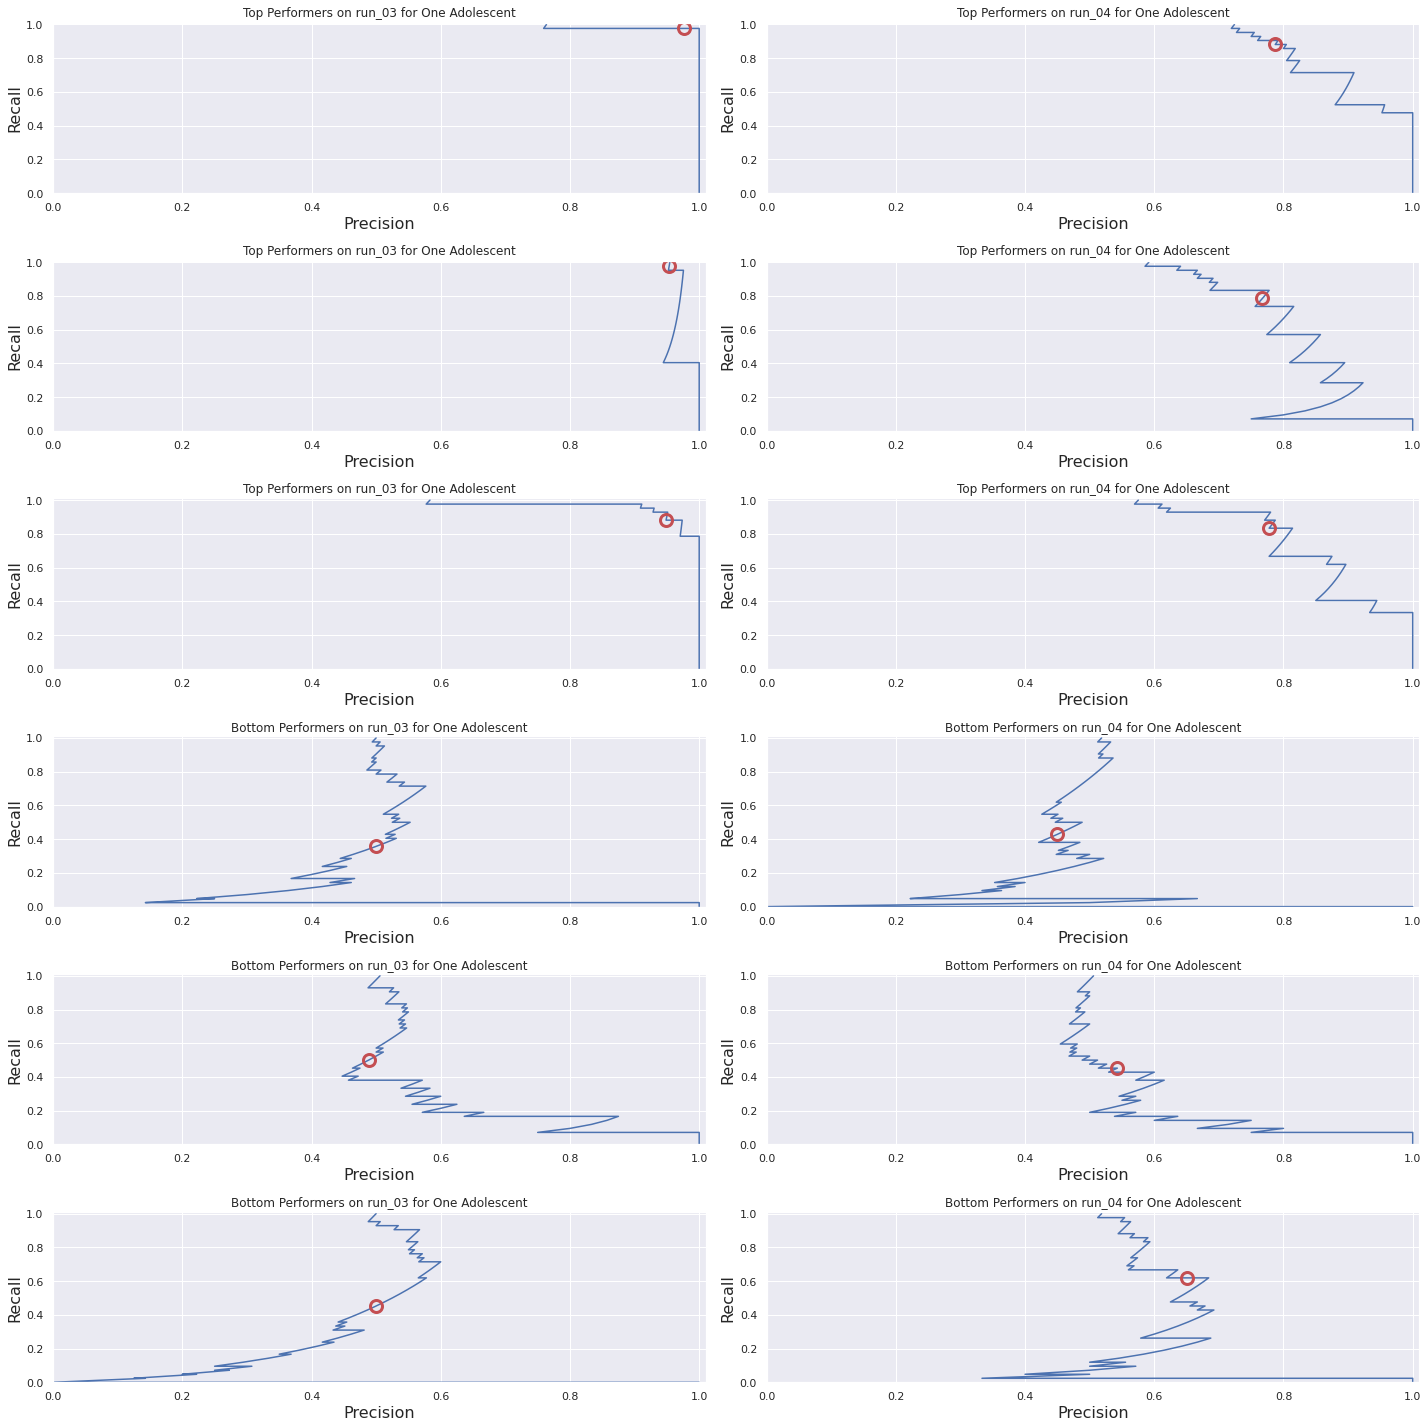

In [106]:
##create precision recall curve
decision_function_labels = np.where(y_test==0,-1,1) #put scores in range of -1, 1 to match svm outputs
fig,axes=plt.subplots(6,2,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
performance_list=['Top Performers','Bottom Performers']
mask_performance_dict = performance_dict['mask']
for performance in list(mask_performance_dict.keys()):
  if performance == 'Top Performers':
    color = 'Greens'
  else:
    color = 'Reds'
  mask_pf_sub = mask_performance_dict[performance]
  for subj_id in list(mask_pf_sub.keys()):
    subj_predicts = mask_pf_sub[subj_id]['predicts']
    for run in list(subj_predicts.keys()):
      decf_scores = subj_predicts[run]['decision_function']
      precision,recall,thresholds = precision_recall_curve(decision_function_labels,decf_scores)
      closest_zero = np.argmin(np.abs(thresholds))
      closest_zero_p = precision[closest_zero]
      closest_zero_r = recall[closest_zero]
      axes[row,column].plot(precision, recall, label='Precision-Recall Curve')

      axes[row,column].set_xlim([0.0, 1.01])
      axes[row,column].set_ylim([0.0, 1.01])

      axes[row,column].plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
      axes[row,column].set_xlabel('Precision', fontsize=16)
      axes[row,column].set_ylabel('Recall', fontsize=16)
      axes[row,column].set_title(f'{performance} on {run} for One {group}')
      column +=1
    column = 0
    row+=1
fig.tight_layout()

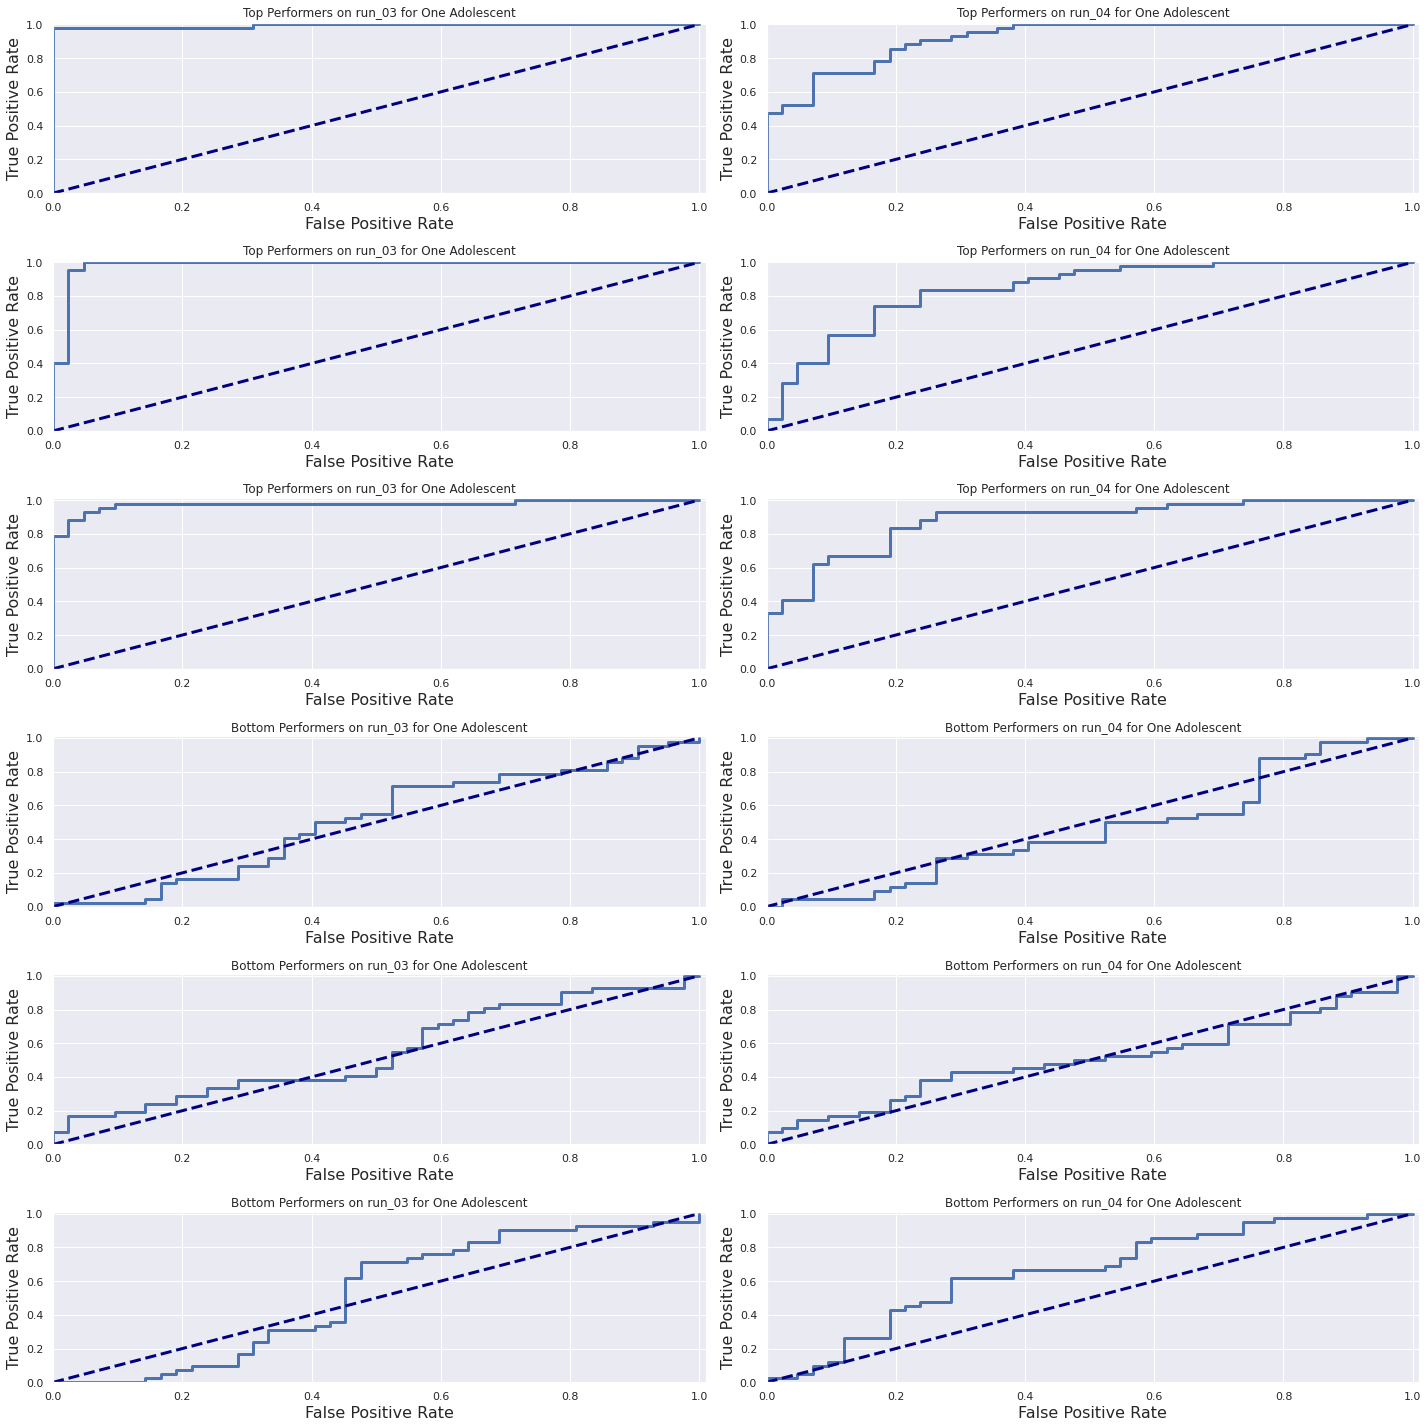

In [107]:
##create precision recall curve
fig,axes=plt.subplots(6,2,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
performance_list=['Top Performers','Bottom Performers']
mask_performance_dict = performance_dict['mask']
for performance in list(mask_performance_dict.keys()):
  if performance == 'Top Performers':
    color = 'Greens'
  else:
    color = 'Reds'
  mask_pf_sub = mask_performance_dict[performance]
  for subj_id in list(mask_pf_sub.keys()):
    subj_predicts = mask_pf_sub[subj_id]['predicts']
    for run in list(subj_predicts.keys()):
      proba_scores = subj_predicts[run]['proba']
      fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_scores[:,1])
      roc_auc_lr = auc(fpr_lr, tpr_lr)
      axes[row,column].plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))

      axes[row,column].set_xlim([0.0, 1.01])
      axes[row,column].set_ylim([0.0, 1.01])
      axes[row,column].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
      axes[row,column].set_xlabel('False Positive Rate', fontsize=16)
      axes[row,column].set_ylabel('True Positive Rate', fontsize=16)
      axes[row,column].set_title(f'{performance} on {run} for One {group}')
      column +=1
    column = 0
    row+=1
fig.tight_layout()

In [ ]:
##create precision recall curve
decision_function_labels = np.where(y_test==0,-1,1) #put scores in range of -1, 1 to match svm outputs
fig,axes=plt.subplots(6,2,figsize=(20,20)) #get figure size
fig.tight_layout() 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale = 1)
column = 0
row = 0
runs_test = ['run_03','run_04']
performance_list=['Top Performers','Bottom Performers']
mask_performance_dict = performance_dict['mask']
for performance in list(mask_performance_dict.keys()):
  if performance == 'Top Performers':
    color = 'Greens'
  else:
    color = 'Reds'
  mask_pf_sub = mask_performance_dict[performance]
  for subj_id in list(mask_pf_sub.keys()):
    subj_predicts = mask_pf_sub[subj_id]['predicts']
    for run in list(subj_predicts.keys()):
      decf_scores = subj_predicts[run]['decision_function']
      axes[row,column] = plot_decision_scores(decf_scores,decision_function_labels,performance,)
      column +=1
    column = 0
    row+=1
fig.tight_layout()

In [24]:
from sklearn import metrics
bmap_dict = {}
data_path = '/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/models/'
for mask_ind in mask_indices:
  mask_dict = get_mask_data(data_path_dict,mask_ind)
  for mask in mask_list[mask_ind]:
    data_file = f'{data_path}{mask}_tr_1_2_subject_models.pkl'
    data = open_pickle(data_file)
    bmap_dict[mask] = {}
    _, ind = make_mask(mask_dict[mask])
    subj_data = data[mask]
    for subj_id in subj_ids:
      bmap_dict[mask][subj_id] = {}
      bmap2,bmap3 = create_bmaps(subj_data[subj_id],ind,affine_image)
      bmap_dict[mask][subj_id]['bmap2'] = bmap2
      bmap_dict[mask][subj_id]['bmap3'] = bmap3
#save file
full_path_name = '/content/drive/My Drive/data/singlesubjectmodels/TR_2_TE_3_4/tr_2_te_3_4_bmaps.pkl'
filehandler = open(full_path_name,"wb")
pickle.dump(bmap_dict,filehandler)
filehandler.close()

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2830: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


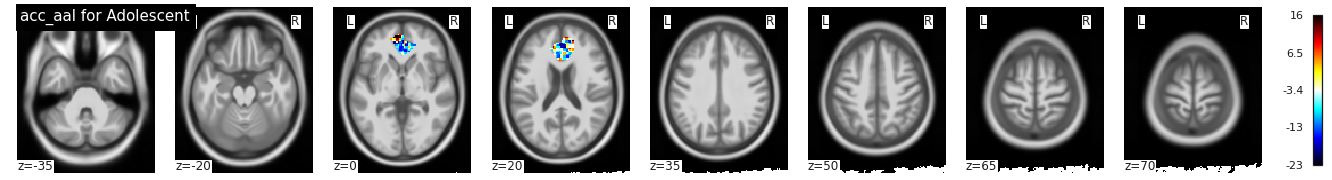

In [104]:
plot_map(bmap_dict['acc_aal']['10004_08693']['bmap3'],'acc_aal','Adolescent',out_fname=None,threshold = 0, t_image = mni_image, display='z')

In [105]:
performance_dict

{'acc_aal': {'Bottom Performers': {'10034_08879': {'X_train': array([[-2.5670195 , -0.89246345, -2.0440602 , ..., -0.29458803,
             0.8056034 ,  0.65576214],
           [-2.0189881 , -1.3665287 , -2.1405303 , ...,  0.9564983 ,
             1.8609929 ,  1.859243  ],
           [-2.6736393 , -2.3290133 , -1.8628681 , ..., -0.7751782 ,
             1.7567178 ,  1.1394212 ],
           ...,
           [-0.19135466, -0.49346012, -0.58082354, ...,  1.17853   ,
             0.45921126,  0.4876119 ],
           [-0.06470103, -0.09725027, -0.11609504, ...,  0.4850527 ,
             0.45551914,  0.38503608],
           [-0.0521706 , -0.3848279 , -0.5107019 , ..., -0.5709704 ,
            -0.02742213, -0.5315888 ]], dtype=float32),
    'model': SVC(C=5, gamma='auto', probability=True),
    'predicts': {'run_03': {'decision_function': array([ 0.53085603,  0.85542167,  0.94285601, -0.33331707, -0.25792131,
             -0.63950038, -0.42993982,  0.25413192,  0.05531727, -0.64337227,
       

In [99]:
np.percentile(bmap_dict['acc_aal']['10004_08693']['bmap2'],90)

0.0